In [3]:
import cx_Oracle
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [10]:
conn = cx_Oracle.connect('js_dev', '123456', 'wind')

In [118]:
query = 'select t.trade_dt, t.s_info_windcode, t.s_val_mv, t.s_val_pe_ttm, t.s_dq_close_today \
         from wind.AShareEODDerivativeIndicator t \
         where t.trade_dt >= \'2010-01-01\' '

In [119]:
df = pd.read_sql_query(query, con=conn)

In [120]:
df.shape

(8509921, 5)

In [121]:
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')

# 市值

In [122]:
mv_df = df.pivot_table('S_VAL_MV', index=['TRADE_DT', 'S_INFO_WINDCODE']).unstack()

# 市盈率

In [320]:
pe_df = df.pivot_table('S_VAL_PE_TTM', index=['TRADE_DT', 'S_INFO_WINDCODE']).unstack()

# 收益率

In [123]:
p_df = df.pivot_table('S_DQ_CLOSE_TODAY', index=['TRADE_DT', 'S_INFO_WINDCODE']).unstack()

In [124]:
r_df = p_df.pct_change()

In [125]:
r_df = r_df.fillna(0)

# Size factor

去除最小的30%市值的股票，然后将剩余股票等比例分成两组

In [349]:
mv_per_df = mv_df.rank(axis=1, pct=True)

In [350]:
mv_per_df = mv_df.rank(axis=1, pct=True)
mv_per_df[(mv_per_df >= 0.3) & (mv_per_df <= 0.65)] = 1
mv_per_df[mv_per_df != 1] = 0

In [351]:
small_ret = (mv_per_df * r_df.shift(-1).values).mean(axis=1)

In [352]:
mv_per_df = mv_df.rank(axis=1, pct=True)
mv_per_df[mv_per_df > 0.65] = 1
mv_per_df[mv_per_df != 1] = 0

In [353]:
big_ret = (mv_per_df * r_df.shift(-1).values).mean(axis=1)

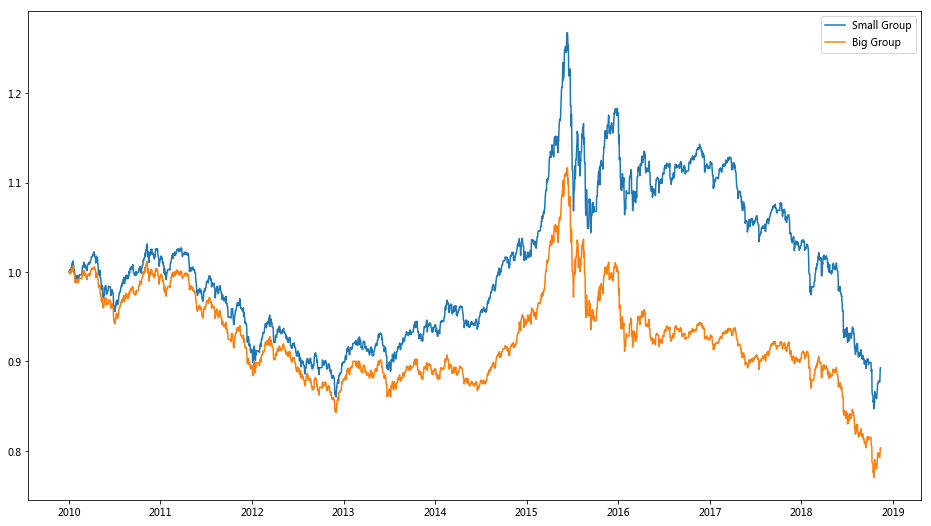

In [362]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((1 + small_ret).cumprod(), label='Small Group')
ax.plot((1 + big_ret).cumprod(), label='Big Group')
ax.legend()

In [363]:
ret = small_ret - big_ret

In [364]:
acc = (1 + ret).cumprod()

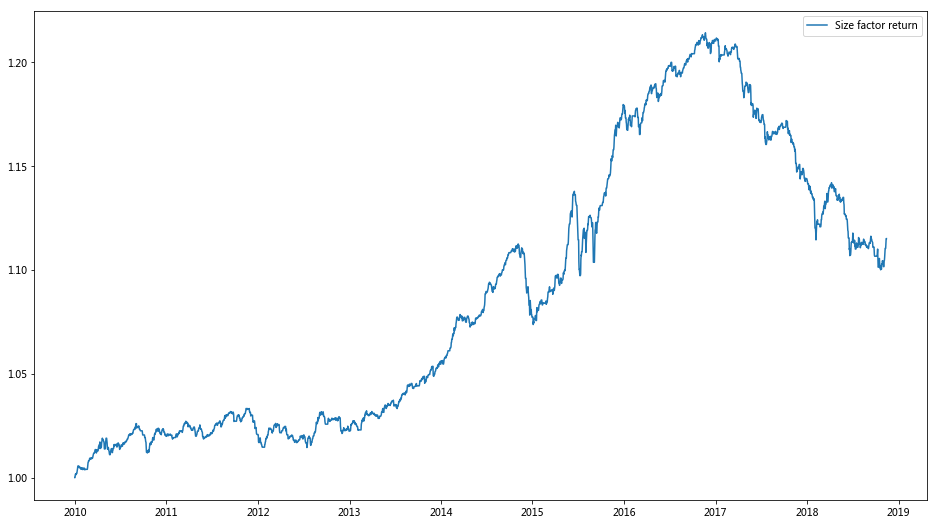

In [366]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(acc, label='Size factor return')
ax.legend()

# Value factor

去除最小的30%市值的股票，然后将剩余股票等比例分成三组

In [367]:
mv_per_df = mv_df.rank(axis=1, pct=True)
mv_per_df[mv_per_df >= 0.3] = 1
mv_per_df[mv_per_df < 0.3] = np.nan

In [368]:
pe_df = pe_df * mv_per_df.values

In [369]:
pe_per_df = pe_df.rank(axis=1, pct=True)
pe_per_df[pe_per_df <= 1./3] = 1
pe_per_df[pe_per_df != 1] = 0

In [370]:
value_ret = (pe_per_df * r_df.shift(-1).values).mean(axis=1)

In [371]:
pe_per_df = pe_df.rank(axis=1, pct=True)
pe_per_df[(pe_per_df > 1./3) & (pe_per_df < 2./3)] = 1
pe_per_df[pe_per_df != 1] = 0

In [372]:
middle_ret = (pe_per_df * r_df.shift(-1).values).mean(axis=1)

In [373]:
pe_per_df = pe_df.rank(axis=1, pct=True)
pe_per_df[pe_per_df >= 2./3] = 1
pe_per_df[pe_per_df != 1] = 0

In [374]:
growth_ret = (pe_per_df * r_df.shift(-1).values).mean(axis=1)

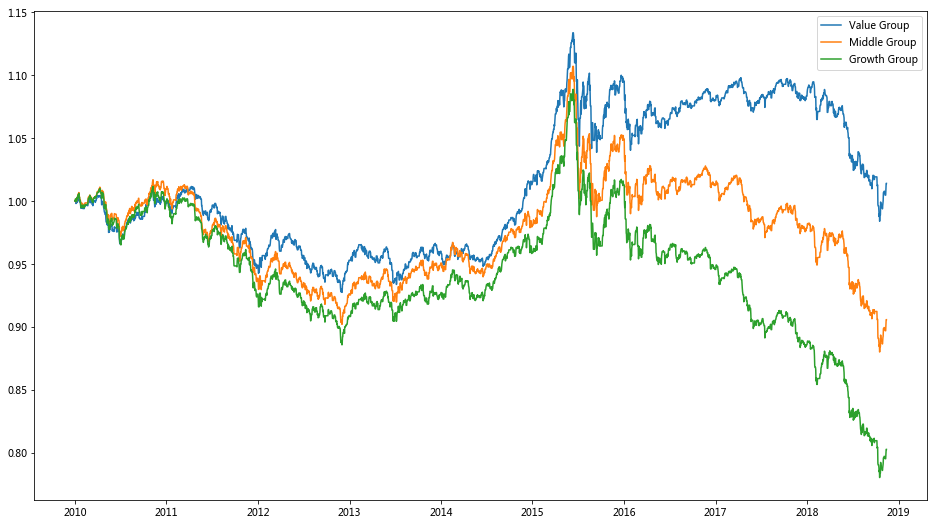

In [375]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((1 + value_ret).cumprod(), label='Value Group')
ax.plot((1 + middle_ret).cumprod(), label='Middle Group')
ax.plot((1 + growth_ret).cumprod(), label='Growth Group')
ax.legend()

In [380]:
ret = value_ret - growth_ret

In [381]:
acc = (1 + ret).cumprod()

Text(0.5,1,u'\u4ef7\u503c\u56e0\u5b50\u6536\u76ca\u51c0\u503c')

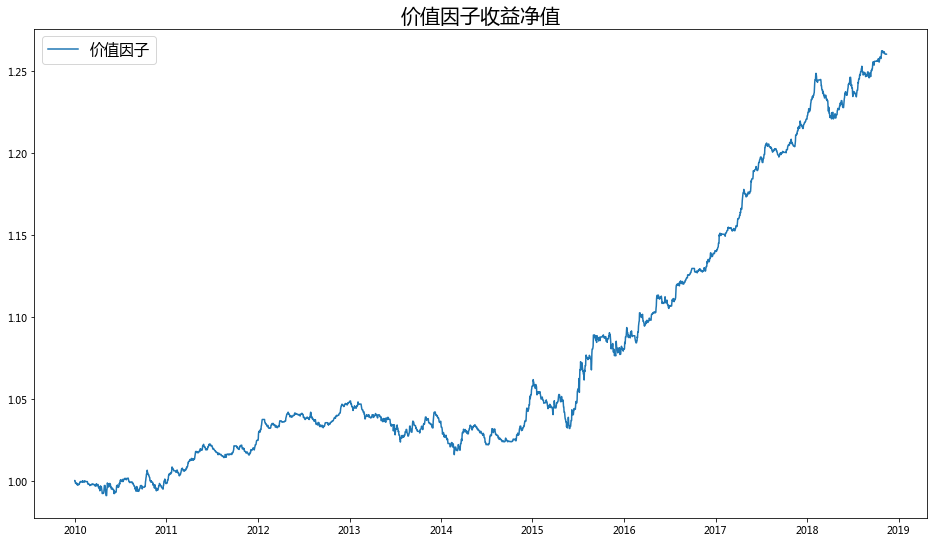

In [382]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(acc, label=u'价值因子')
ax.legend(fontsize=15)
ax.set_title(u'价值因子收益净值', fontsize=20)